In [1]:
import  torch
from    torch import nn
from    torch import optim
from    torch.nn import functional as F
import  numpy as np
from    data import load_data, preprocess_features, preprocess_adj
from    model import GCN
from    utils import masked_loss, masked_acc, all_loss
from    numpy import linalg as LA

In [2]:
import  argparse

args = argparse.ArgumentParser()
args.add_argument('--dataset', default='cora')
args.add_argument('--model', default='gcn')
args.add_argument('--learning_rate', type=float, default=0.01)
args.add_argument('--epochs', type=int, default=200)
args.add_argument('--hidden', type=int, default=16)
args.add_argument('--dropout', type=float, default=0.5)
args.add_argument('--weight_decay', type=float, default=5e-4)
args.add_argument('--early_stopping', type=int, default=10)
args.add_argument('--max_degree', type=int, default=3)


args = args.parse_args(['--dataset', 'cora'])
print(args)

Namespace(dataset='cora', dropout=0.5, early_stopping=10, epochs=200, hidden=16, learning_rate=0.01, max_degree=3, model='gcn', weight_decay=0.0005)


In [3]:
import  torch
from    torch import nn
from    torch import optim
from    torch.nn import functional as F

import  numpy as np
from    data import load_data, preprocess_features, preprocess_adj
from    model import GCN
# from    config import  args
from    utils import masked_loss, masked_acc


seed = 123
np.random.seed(seed)
torch.random.manual_seed(seed)


# load data
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask = load_data(args.dataset)
print('adj:', adj.shape)
print('features:', features.shape)
print('y:', y_train.shape, y_val.shape, y_test.shape)
print('mask:', train_mask.shape, val_mask.shape, test_mask.shape)

# D^-1@X
features = preprocess_features(features) # [49216, 2], [49216], [2708, 1433]
supports = preprocess_adj(adj)

device = torch.device('cuda')
train_label = torch.from_numpy(y_train).long().to(device)
num_classes = train_label.shape[1]
train_label = train_label.argmax(dim=1)
train_mask = torch.from_numpy(train_mask.astype(np.int)).to(device)
val_label = torch.from_numpy(y_val).long().to(device)
val_label = val_label.argmax(dim=1)
val_mask = torch.from_numpy(val_mask.astype(np.int)).to(device)
test_label = torch.from_numpy(y_test).long().to(device)
test_label = test_label.argmax(dim=1)
test_mask = torch.from_numpy(test_mask.astype(np.int)).to(device)

i = torch.from_numpy(features[0]).long().to(device)
v = torch.from_numpy(features[1]).to(device)
feature = torch.sparse.FloatTensor(i.t(), v, features[2]).to(device)

i = torch.from_numpy(supports[0]).long().to(device)
v = torch.from_numpy(supports[1]).to(device)
support = torch.sparse.FloatTensor(i.t(), v, supports[2]).float().to(device)
print('x :', feature)
print('sp:', support)
num_features_nonzero = feature._nnz()
feat_dim = feature.shape[1]


net = GCN(feat_dim, num_classes, num_features_nonzero, args)
net.to(device)
optimizer = optim.Adam(net.parameters(), lr=args.learning_rate)

net.train()
for epoch in range(300):

    out = net((feature, support))
#     out = out[0]
    loss = masked_loss(out, train_label, train_mask)
    loss += args.weight_decay * net.l2_loss()

    acc = masked_acc(out, train_label, train_mask)
    acc_other = masked_acc(out, test_label, test_mask)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:

        print(epoch, loss.item(), acc.item())

net.eval()

out = net((feature, support))
# out = out[0]
acc = masked_acc(out, test_label, test_mask)
print('test:', acc.item())

adj: (2708, 2708)
features: (2708, 1433)
y: (2708, 7) (2708, 7) (2708, 7)
mask: (2708,) (2708,) (2708,)
x : tensor(indices=tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
                       [1274, 1247, 1194,  ...,  329,  186,   19]]),
       values=tensor([0.1111, 0.1111, 0.1111,  ..., 0.0769, 0.0769, 0.0769]),
       device='cuda:0', size=(2708, 1433), nnz=49216, layout=torch.sparse_coo)
sp: tensor(indices=tensor([[   0,  633, 1862,  ..., 1473, 2706, 2707],
                       [   0,    0,    0,  ..., 2707, 2707, 2707]]),
       values=tensor([0.2500, 0.2500, 0.2236,  ..., 0.2000, 0.2000, 0.2000]),
       device='cuda:0', size=(2708, 2708), nnz=13264, layout=torch.sparse_coo)
input dim: 1433
output dim: 7
num_features_nonzero: 49216


/home/yancheng/label_noise/GCN-PyTorch-master/utils.py:51: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603728993639/work/aten/src/ATen/native/IndexingUtils.h:25.)
  i = i[:, dropout_mask]
/home/yancheng/label_noise/GCN-PyTorch-master/utils.py:52: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603728993639/work/aten/src/ATen/native/IndexingUtils.h:25.)
  v = v[dropout_mask]


0 13.535268783569336 0.09285714477300644
10 11.825864791870117 0.1428571343421936
20 10.288409233093262 0.2142857015132904
30 8.996515274047852 0.30000001192092896
40 7.904073238372803 0.3499999940395355
50 6.94911527633667 0.38571426272392273
60 6.148776054382324 0.44285711646080017
70 5.367528915405273 0.5642856955528259
80 4.837517738342285 0.5857142806053162
90 4.337122917175293 0.5714285373687744
100 3.8980135917663574 0.6499999761581421
110 3.481443405151367 0.6571428179740906
120 3.102293014526367 0.6500000357627869
130 2.82582950592041 0.6857143044471741
140 2.570024013519287 0.7428570985794067
150 2.2750911712646484 0.7642857432365417
160 2.0544393062591553 0.8214285969734192
170 1.9246575832366943 0.8214285969734192
180 1.7076653242111206 0.8928570747375488
190 1.5484225749969482 0.9071428179740906
200 1.4315887689590454 0.8785713911056519
210 1.3597629070281982 0.9214285612106323
220 1.2655247449874878 0.9428570866584778
230 1.2521538734436035 0.8999999761581421
240 1.115472

In [4]:
net.train()

out = net((feature, support))

In [5]:
all_loss = all_loss(out, train_label, train_mask)

In [11]:
grad_all_data = []
for i in range(all_loss.shape[0]):
    optimizer.zero_grad()
    all_loss[i].backward(retain_graph = True)
    params_grad = []
    for key, value in net.named_parameters():
        if value.grad is not None:
            grad_vector = value.grad.reshape([-1])
            params_grad.append(grad_vector)
    params_grad_all = torch.cat((params_grad),0)
    params_grad_all = params_grad_all.reshape([1, -1]).cpu()
    grad_all_data.append(params_grad_all)
grad_all_data_m = torch.cat((grad_all_data), 0)
gram = torch.matmul(grad_all_data_m, torch.transpose(grad_all_data_m, 0, 1)).numpy()
gram = gram / all_loss.shape[0]
e, v = LA.eig(gram)

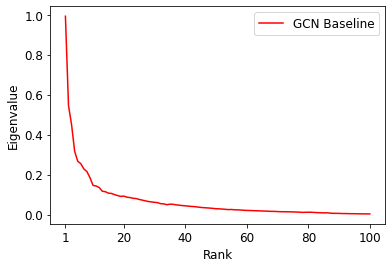

In [12]:
import matplotlib.pyplot as plt

top = 100
x_label = np.array(range(1,top+1))
plt.plot(x_label[:top], e[:top], color='red', label="GCN Baseline")
plt.xticks([1,20,40,60,80,100],fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Rank',  fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.legend(fontsize=12)
plt.savefig("./spectral-cite.png", dpi=300)